In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['JAX_PLATFORMS']="cpu"


import sys
sys.path.append("./src")

from flax import nnx
import jax 
import jax.numpy as jnp
import optax
import numpy as np

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

import time
import diffrax

In [49]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial

@partial(jax.jit, static_argnums=[1,2,3])  # type: ignore
def make_moons_jax(key, n_samples=100, shuffle=True, noise=None):
    """Make two interleaving half circles using JAX.

    Args:
        n_samples: The total number of points generated.
        shuffle: Whether to shuffle the samples.
        noise: Standard deviation of Gaussian noise added to the data.
        random_state: A JAX random.PRNGKey for reproducibility.

    Returns:
        X: A JAX array of shape (n_samples, 2) containing the generated samples.
        y: A JAX array of shape (n_samples,) containing the integer labels (0 or 1)
           for class membership of each sample.
    """

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Generate points for the outer moon (label 0)
    outer_circ_t = random.uniform(key, shape=(n_samples_out,)) * jnp.pi
    key, subkey = random.split(key)
    outer_circ_x = jnp.cos(outer_circ_t)
    outer_circ_y = jnp.sin(outer_circ_t)
    X_outer = jnp.vstack([outer_circ_x, outer_circ_y]).T

    # Generate points for the inner moon (label 1)
    inner_circ_t = random.uniform(subkey, shape=(n_samples_in,)) * jnp.pi
    key, subkey = random.split(key)
    inner_circ_x = 1 - jnp.cos(inner_circ_t)
    inner_circ_y = 0.5 - jnp.sin(inner_circ_t)
    X_inner = jnp.vstack([inner_circ_x, inner_circ_y]).T

    # Combine the moons
    X = jnp.vstack([X_outer, X_inner])
    y = jnp.hstack([jnp.zeros(n_samples_out, dtype=jnp.int32), jnp.ones(n_samples_in, dtype=jnp.int32)])

    if noise is not None:
        # Add Gaussian noise
        key, subkey = random.split(key)
        X += random.normal(subkey, shape=X.shape) * noise

    if shuffle:
        # Shuffle the data
        key, subkey = random.split(key)
        permutation = random.permutation(subkey, n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    key1, key2, key3 = jax.random.split(key, 3)
    
    # Generate x1: uniform random between -2 and 2
    x1 = jax.random.uniform(key1, (batch_size,)) * 4 - 2
    
    # Generate random values for x2
    rand_uniform = jax.random.uniform(key2, (batch_size,))
    rand_int = jax.random.randint(key3, (batch_size,), 0, 2) * 2
    x2_ = rand_uniform - rand_int
    
    # Calculate x2
    x2 = x2_ + (jnp.floor(x1) % 2)
    
    # Stack x1 and x2 and scale
    data = jnp.stack([x1, x2], axis=1) / 0.45
    
    return data


@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax_v2(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45
    
    return data

In [50]:
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_moons_jax(key, batch_size, shuffle=True, noise=0.1)[0]

#     return x

@partial(jax.jit, static_argnums=[1])  # type: ignore
def inf_train_gen(key, batch_size: int = 200):
    x = make_boxes_jax_v2(key, batch_size)

    return x

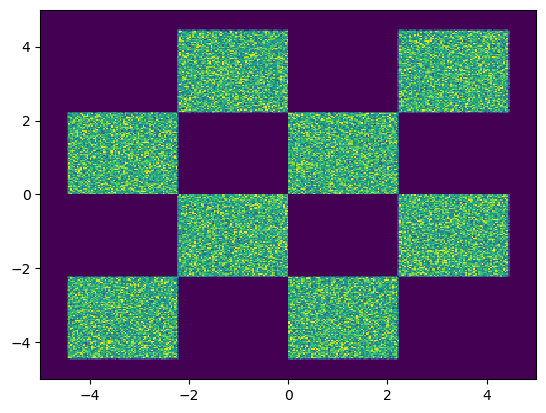

In [51]:
samples = inf_train_gen(jax.random.PRNGKey(0), 500_000)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm)


plt.show()

In [214]:
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

In [58]:
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
            
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        # x = self.bn1(x)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        # x = self.bn2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        # x = self.bn3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        # x = self.bn4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [59]:
# training arguments
lr = 0.001
iterations = 20001
print_every = 2000
hidden_dim = 512

# velocity field model init
vf = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

# init optimizer
optimizer = nnx.Optimizer(vf, optax.adam(lr))

In [60]:
batch_size = 1024

In [215]:
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

def loss_fn(vf, batch):
    path_sample = path.sample(*batch)
    return jnp.mean(jnp.square(vf(path_sample.x_t, path_sample.t) - path_sample.dx_t))

@nnx.jit
def train_step(vf, optimizer, batch):
    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(vf, batch)
    optimizer.update(grads)  # In-place updates.

    return loss

In [62]:
start_time = time.time()
key = jax.random.PRNGKey(0)
for i in range(iterations):
    key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
    x_1 = inf_train_gen(subkey1, batch_size=batch_size) # sample data
    x_0 = jax.random.normal(subkey2, x_1.shape)
    t = jax.random.uniform(subkey3, x_1.shape[0])

    batch = (x_0, x_1, t)
    loss = train_step(vf, optimizer, batch)  # update model parameters

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()

| iter   2000 | 16.75 ms/step | loss    3.831 
| iter   4000 | 15.96 ms/step | loss    3.914 
| iter   6000 | 15.93 ms/step | loss    3.785 
| iter   8000 | 15.87 ms/step | loss    3.566 
| iter  10000 | 15.72 ms/step | loss    3.767 
| iter  12000 | 15.99 ms/step | loss    3.667 
| iter  14000 | 15.89 ms/step | loss    3.721 
| iter  16000 | 15.73 ms/step | loss    3.928 
| iter  18000 | 15.84 ms/step | loss    4.013 
| iter  20000 | 15.94 ms/step | loss    3.370 


In [63]:
vf.eval()

In [216]:
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
# eps_time = 1e-2
T = jnp.linspace(0,1,10)  # sample times

# x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))  # initial conditions
solver = ODESolver(velocity_model=vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='dopri5', step_size=step_size, return_intermediates=True)

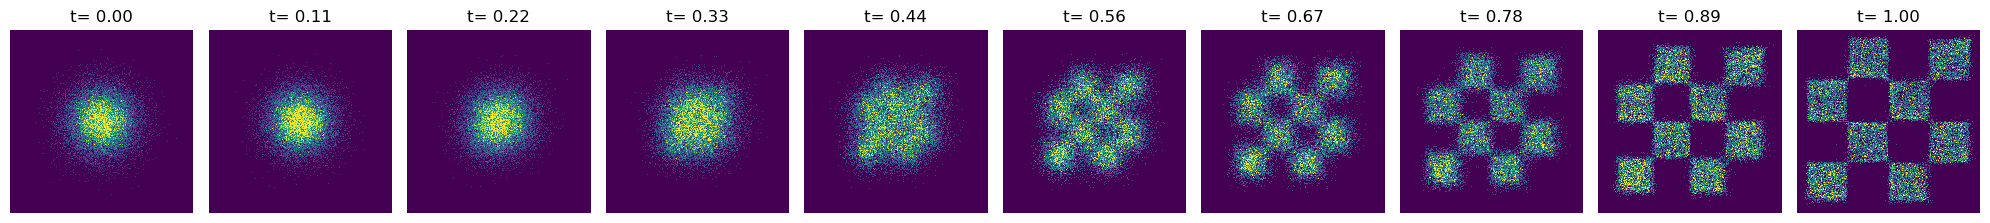

In [217]:
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

# sample the likelihood

In [218]:
import numpyro.distributions as dist

In [219]:


# sample with likelihood

T = jnp.array([1., 0.])  # sample times
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

     


In [220]:
# source distribution is an isotropic gaussian
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(2), jnp.ones(2)), 1).log_prob

     


In [232]:
_, exact_log_p = solver.compute_likelihood(x_1=x_1, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

In [229]:
y_samples, exact_log_p = solver.compute_likelihood(x_1=x_1, time_grid=[1.0,0.8, 0.4, 0.0],method='dopri5', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density, return_intermediates=True)

In [233]:
exact_log_p.shape

(1, 40000)

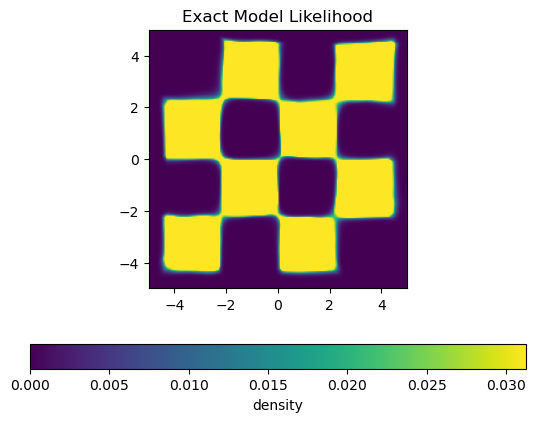

In [235]:
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))


cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

cmin = 0.0
cmax = 1/32  # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
ax.set_title('Exact Model Likelihood')

# Use the current figure/axis for the colorbar
plt.colorbar(im, ax=ax, orientation='horizontal', label='density')
plt.show()



     


In [145]:
from flow_matching.utils import divergence, ModelWrapper


In [204]:
vf_wrapped = lambda x, t: jnp.squeeze(vf(x, t))


def dynamics_func(t, states, args):
    xt, _ = states
    ut = jnp.squeeze(vf_wrapped(xt, t))
    div = jnp.squeeze(divergence(vf_wrapped, xt, t))

    return ut, div
#%%


In [201]:
x__ = x_1[:100, :]
y_init = (x__, jnp.ones(x__.shape[0]))  # initial conditions

In [202]:
vf(x__, 0.0).shape

(100, 2)

In [205]:
divergence(vf_wrapped, x__, 0.0).shape

(100,)

In [206]:
res=dynamics_func(0, y_init, None)

In [207]:
res[0].shape, res[1].shape

((100, 2), (100,))

In [208]:
import diffrax
solver_ = diffrax.Dopri5()
stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-5)

term = diffrax.ODETerm(dynamics_func)

In [209]:
sol, log_det = diffrax.diffeqsolve(
    term,
    solver_,
    t0=1.0,
    t1=0.0,
    dt0=-0.05,
    y0=y_init,
    saveat=diffrax.SaveAt(t1=True),
    stepsize_controller=stepsize_controller,
).ys

In [210]:
log_p0 = gaussian_log_density
x_source = sol

source_log_p = log_p0(x_source)

In [211]:
source_log_p.shape, log_det.shape

((1, 100), (1, 100))

In [212]:
source_log_p + log_det

Array([[-16.166748 , -15.927822 , -15.713073 , -15.518628 , -15.394298 ,
        -15.345919 , -15.255574 , -15.1722555, -15.190971 , -15.252517 ,
        -15.318355 , -15.375887 , -15.422589 , -15.463172 , -15.502832 ,
        -15.539008 , -15.575727 , -15.6294   , -15.699176 , -15.77476  ,
        -15.851168 , -15.926849 , -16.000359 , -16.069757 , -16.133907 ,
        -16.191908 , -16.243675 , -16.289345 , -16.329296 , -16.36389  ,
        -16.393307 , -16.417835 , -16.437113 , -16.451027 , -16.459211 ,
        -16.461306 , -16.456984 , -16.445917 , -16.427893 , -16.402615 ,
        -16.370232 , -16.331514 , -16.28839  , -16.24438  , -16.205288 ,
        -16.178833 , -16.175041 , -16.204245 , -16.274458 , -16.3867   ,
        -16.532553 , -16.696184 , -16.859266 , -17.006199 , -17.129488 ,
        -17.232172 , -17.32167  , -17.400175 , -17.470901 , -17.559    ,
        -17.699825 , -17.903742 , -18.157436 , -18.443415 , -18.746067 ,
        -19.052053 , -19.350243 , -19.630878 , -19.